In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.mgu import MGU

In [2]:
class GenericMGU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        
        self.mgu = MGU(self.in_no, self.H_no, True, device)
        self.linear = nn.Linear(self.H_no, 1)
        
    def forward(self, S):
        T_data = S.shape[0]
        
        S = S.unsqueeze(1)
        lstm_out = self.mgu(S)
        out = self.linear(lstm_out.squeeze(1)).flatten()
        
        return out


In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 50
layer_no = 2
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericMGU(T_no, H_no, layer_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

35951


In [7]:
for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])))
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])))
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse, train_score, loss.item())


<ipython-input-7-955f6c377c63>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.0010194778442382812 0.031873371452093124 -0.0030111074447631836 0.03885655477643013
49 0.051392436027526855 0.0258344579488039 0.04188501834869385 0.02848580665886402
99 0.18918496370315552 0.022209124639630318 0.18114036321640015 0.025072162970900536
149 0.27440083026885986 0.020163878798484802 0.22328031063079834 0.024475879967212677
199 0.2669353485107422 0.02006550319492817 0.2623071074485779 0.020676296204328537
249 0.2822243571281433 0.0195770263671875 0.232160747051239 0.02324683777987957
299 0.2831898331642151 0.01953960210084915 0.2962188124656677 0.017199479043483734
349 0.27992451190948486 0.019721772521734238 0.24350190162658691 0.027426667511463165
399 0.27525949478149414 0.019727811217308044 0.30358874797821045 0.0247795507311821
449 0.2946040630340576 0.01920648105442524 0.2979236841201782 0.02412620559334755
499 0.2955015301704407 0.01917361468076706 0.23342519998550415 0.027208756655454636
549 0.2936415672302246 0.019258465617895126 0.24871915578842163 0.0221939682

KeyboardInterrupt: 

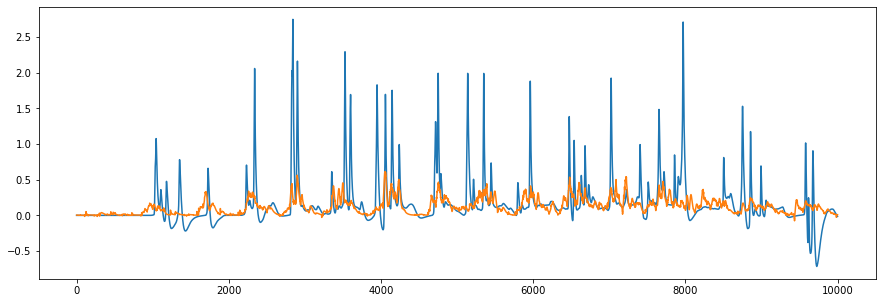

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

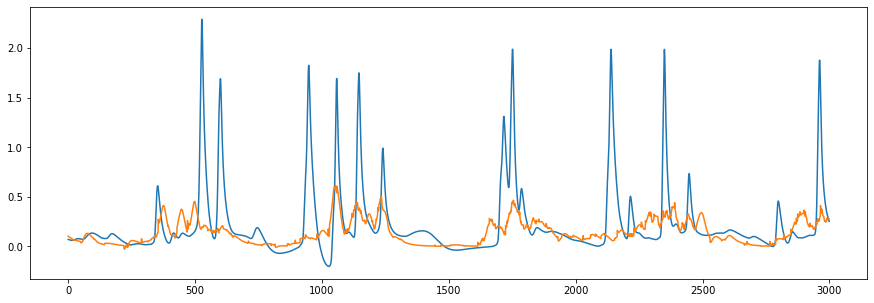

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

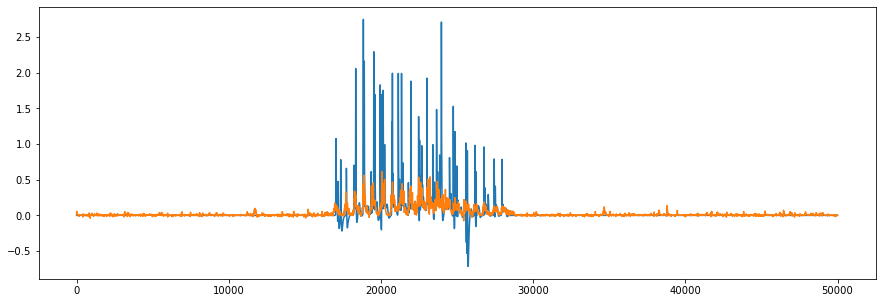

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

In [11]:
output = np.save("/media/hdd01/sklee/CA1_clust4-60/NA_gru_l2_h50_test.npy", test_V_pred.cpu().detach().numpy())

In [38]:
W1 = model.lstm.weight_ih_l0.cpu().detach().numpy()[:50]
W2 = model.lstm.weight_ih_l0.cpu().detach().numpy()[50:100]
W3 = model.lstm.weight_ih_l0.cpu().detach().numpy()[100:150]

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
W1_new = pca.fit_transform(W3.T)
scores = pca.explained_variance_ratio_
print(scores)

[0.37424642 0.10714925]


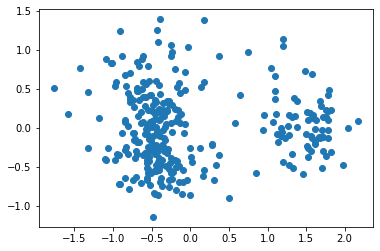

In [42]:
plt.scatter(W1_new[:,0], W1_new[:,1], cmap="jet")

In [43]:
idx = np.where(W1_new[:,0] > 0.75)
print(idx)

In [36]:
W1_norm = np.sum(np.abs(W1),0)
W2_norm = np.sum(np.abs(W2),0)
W3_norm = np.sum(np.abs(W3),0)

print(np.flip(np.argsort(W1_norm))[:10])
print(np.flip(np.argsort(W2_norm))[:10])
print(np.flip(np.argsort(W3_norm))[:10])

[ 26  24 137 208  69 185 214 262 135  18]
[  0  23 241 292 151 273 141   8 280 206]
[ 22 143 140 117  23 119 116 109 118 147]


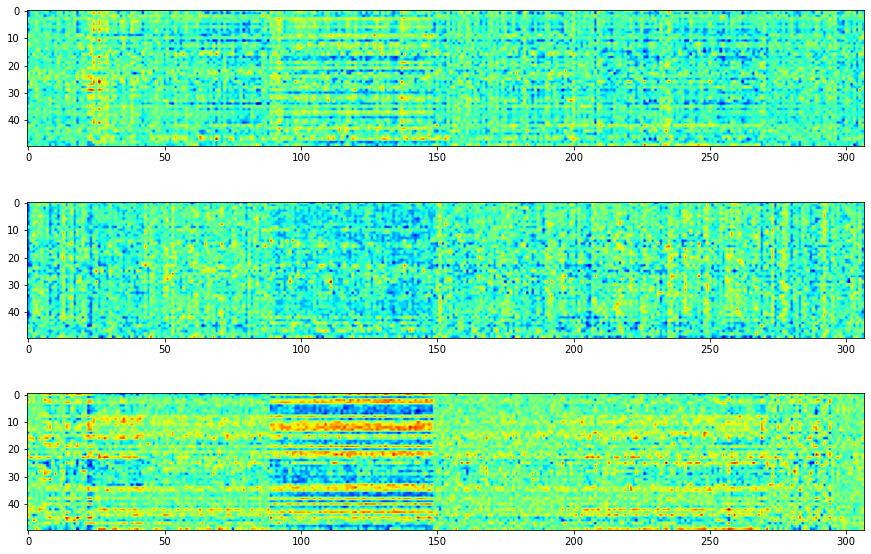

In [29]:
fig, axs = plt.subplots(nrows=3, figsize=(15,10))
axs[0].imshow(W1, cmap="jet")
axs[1].imshow(W2, cmap="jet")
axs[2].imshow(W3, cmap="jet")